In [1]:
import sys; sys.path.append('../../wwa'); from wwa import *

## Extract gridded data for model fitting

In [77]:
fl = glob.glob("../../00_WWA_project_folder/ephemeral/Asia_Heatwave/obs/obs_fields/*.nc")

domain = {"EA" : [118,130,4,20], "WA" : [30,50,25,40]}

In [80]:
for fnm in glob.glob("../../00_WWA_project_folder/ephemeral/Asia_Heatwave/obs/obs_fields/*A.nc"):
    
    xn,xx,yn,yx = domain[fnm[-5:-3]]
    
    da = xr.open_dataset(fnm).sel(lon = slice(xn,xx), lat = slice(yn,yx))
    da = da.assign_coords(time = da.time.dt.year).rename(time = "year")

    if "mswx" in fnm:
        da = da.air_temperature
    else:
        da = da.tmax
    
    # mask off the sea
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
    da = da.where(rm == 0)
    
    # filter any cells with only partial data
    da = da.where(np.isnan(da).sum("year") == 0)
    
    # flatten & save as .csv for transfer to R
    da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas().to_csv("data/"+fnm.split("/")[-1].split("_")[0]+"_"+fnm[-5:-3]+"_flattened.csv")
    
    # save map for easier reconstruction
    da.mean("year").to_netcdf("data/"+fnm.split("/")[-1].split("_")[0]+"_"+fnm[-5:-3]+"tmplt.nc")

## Reshape dataframe into maps

In [25]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [28]:
ds = "mswx"
domain = "WA"
    
# load map to be used to reshape
if ds == "mswx":
    tmplt = xr.open_dataset("data/"+ds+"_"+domain+"_tmplt.nc").air_temperature
else:
    tmplt = xr.open_dataset("data/"+ds+"_"+domain+"_tmplt.nc").tmax

df = pd.read_csv("res/res_"+ds+"_"+domain+"_gridded.csv", index_col = 0)

mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
mdl_res.to_netcdf("res/res_"+ds+"_"+domain+"_gridded.nc")

## Plot maps - EA

In [95]:
datasets = ["cpc", "era5", "mswx"]

# load results of model fitted to gridded data
domain = "EA"
da_res = { ds : xr.open_dataset("res/res_"+ds+"_"+domain+"_gridded.nc") for ds in datasets }

grid_ticks = {"xlocs" : range(120,140, 2), "ylocs" : range(4,22,2)}

In [116]:
plot_kwargs = {"mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000, "label" : ""},
               "disp"       : {"cmap" : "viridis", "vmin" : 0, "label" : ""},
               "alpha_gmst" : {"cmap" : "RdBu_r", "vmin" : -2, "vmax" : 2, "label" : ""},
               "alpha_nino" : {"cmap" : "RdBu_r", "vmin" : -2, "vmax" : 2, "label" : ""},
               "event_magnitude" : {"cmap" : "YlOrRd", "vmin" : 25, "vmax" : 40, "label" : "Temperature (°C)"},
               "return_period"   : {"cmap" : "viridis", "vmin" : 0, "vmax" : 50, "label" : "Return period (years)"},
               "rp_neut"         : {"cmap" : "viridis", "vmin" : 0, "vmax" : 250, "label" : ""},
               "PR_hist"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20, "label" : ""},
               "PR_neut"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20, "label" : ""},
               "dI_abs_hist" : {"cmap" : "RdBu_r", "vmin" : -3, "vmax" : 3, "label" : "Change in temperature (°C) following 1.2°C increase in GMST"},
               "dI_abs_neut" : {"cmap" : "RdBu_r", "vmin" : -0.75, "vmax" : 0.75,  "label" : "Change in temperature (°C) due to current El Niño event"}}

mapproj = cartopy.crs.PlateCarree()

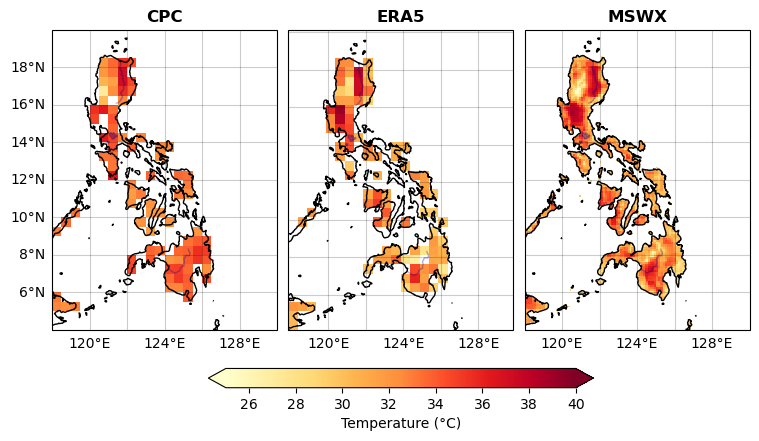

In [117]:
varnm = "event_magnitude"

fig, axs = plt.subplots(ncols = 3, figsize = (9,5), dpi = 100, subplot_kw={"projection" : mapproj})
plt.subplots_adjust(wspace = 0.05)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "shrink" : 0.9, "pad" : 0.1, "extend" : "both"} | {"label" : plot_kwargs[varnm]["label"]}

for i in range(len(datasets)):
    ds = datasets[i]
    da = da_res[ds]
    ax = axs[i]
    
    cbar = da[varnm].plot(ax = ax, add_colorbar = False, **plot_kwargs[varnm])
    
    ax.set_title(ds.upper(), fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom"], **grid_ticks)
    
axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"], **grid_ticks)
plt.colorbar(cbar, ax = axs, **cbar_kwargs)
# plt.suptitle(main[varnm], fontweight = "bold", y = 1.01)
plt.savefig("gridded-trend_"+re.sub("_","-",varnm)+"_"+domain+".png")

## Plot maps - WA

In [120]:
datasets = ["cpc", "era5", "mswx"]

# load results of model fitted to gridded data
domain = "WA"
da_res = { ds : xr.open_dataset("res/res_"+ds+"_"+domain+"_gridded.nc") for ds in datasets }

grid_ticks = {"xlocs" : np.arange(32.5,52.5,5), "ylocs" : np.arange(22.5,42.5,5)}

sf = gpd.read_file("sf_Israel-Jordan")

In [133]:
plot_kwargs = {"mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000, "label" : ""},
               "disp"       : {"cmap" : "viridis", "vmin" : 0, "label" : ""},
               "alpha_gmst" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500, "label" : ""},
               "event_magnitude" : {"cmap" : "YlOrRd", "vmin" : 25, "vmax": 40, "label" : ""},
               "return_period"   : {"cmap" : "viridis", "vmin" : 1, "vmax" : 25, "label" : ""},
               "PR"              : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20, "label" : ""},
               "dI_abs"          : {"cmap" : "RdBu_r", "vmin" : -4, "vmax" : 4, "label" : "Change in temperature (°C) following 1.2°C increase in GMST"}}

mapproj = cartopy.crs.PlateCarree()

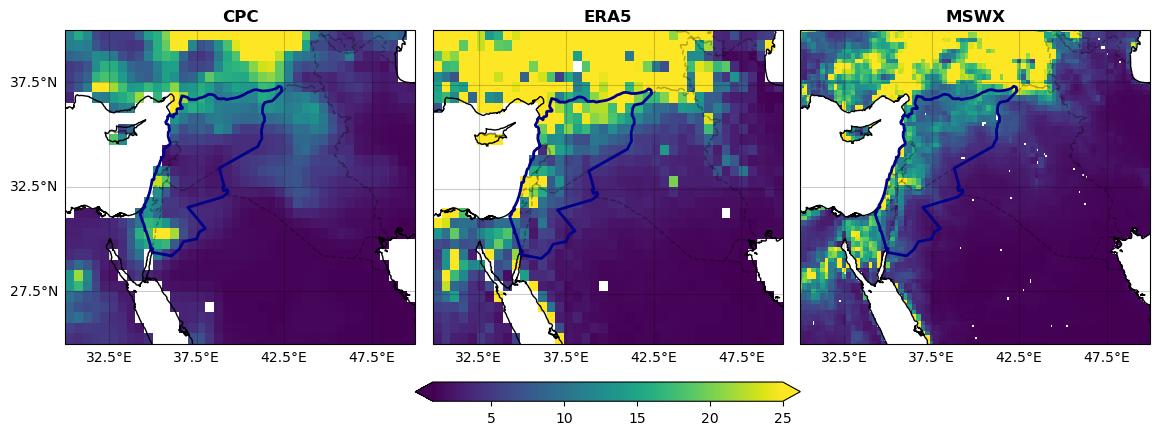

In [134]:
varnm = "return_period"

fig, axs = plt.subplots(ncols = 3, figsize = (14,5), dpi = 100, subplot_kw={"projection" : mapproj})
plt.subplots_adjust(wspace = 0.05)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "shrink" : 0.9, "pad" : 0.1, "extend" : "both"} | {"label" : plot_kwargs[varnm]["label"]}

for i in range(len(datasets)):
    ds = datasets[i]
    da = da_res[ds]
    ax = axs[i]
    
    cbar = da[varnm].plot(ax = ax, add_colorbar = False, **plot_kwargs[varnm])
    
    ax.set_title(ds.upper(), fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.3, ls = "--")
    
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom"], **grid_ticks)
    
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)
    
axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"], **grid_ticks)
plt.colorbar(cbar, ax = axs, **cbar_kwargs)
# plt.suptitle(main[varnm], fontweight = "bold", y = 1.01)
plt.savefig("gridded-trend_"+re.sub("_","-",varnm)+"_"+domain+".png")